### Understanding GB Classification with Example

In [68]:
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

df = pd.DataFrame(
                  [
                      [6.82, 118, 0],
                      [6.36, 125, 1],
                      [5.39, 99, 1],
                      [5.50, 106, 1],
                      [6.39, 148, 0],
                      [9.13, 148, 1],
                      [7.17, 147, 1],
                      [7.72, 72, 0]
                   ], columns = ['cgpa',	'iq',	'is_placed']
)

df

,cgpa,iq,is_placed
0,6.82,118,0
1,6.36,125,1
2,5.39,99,1
3,5.50,106,1
4,6.39,148,0
5,9.13,148,1
6,7.17,147,1
7,7.72,72,0


# Gradient Boosting Classification Example

## Dataset Description
- **Dataset:** Classification dataset
- **Features:** `cgpa`, `iq`
- **Target:** `is_placed` (0 or 1)
- **Number of samples:** 8 students

## Gradient Boosting Overview
- **Goal:** Apply Gradient Boosting to predict if a new student will be placed or not.
- **Approach:** Construct multiple small models and combine them in a stage-wise manner to create a more accurate Gradient Boosting model.
- **Models Used:** Total of 3 models:
  1. **f0**: Initial simple model
  2. **f1**: Decision Tree model
  3. **f2**: Another Decision Tree model


## Model Stages

### Stage 1
- **Objective:** Start with a simple model. For classification, this is a basic model that calculates log(odds).
- **Log(Odds) Calculation:**
  - Calculate the ratio of the number of 1's to 0's in the target column.
  - Compute the log of this ratio (using base e).

  \[
  log_odds = log(Number of 1's / Number of 0's)
  \]
- In this example: `log_odds = log(5 / 3)`

- **Initial Prediction:**
  - Convert log(odds) to probability using the formula:

\[
p = 1 / (1 + exp(-log_odds))
\]

  - **Initial Model Predictions:**
  
- df['pre1(log-odds)'] = np.log(5/3)
- df['pre1(probability)'] = 1 / (1 + np.exp(-df['pre1(log-odds)']))

   

  


In [69]:
# initial prediction

df['pre1(log-odds)'] = np.log(5/3)
df

,cgpa,iq,is_placed,pre1(log-odds)
0,6.82,118,0,0.510826
1,6.36,125,1,0.510826
2,5.39,99,1,0.510826
3,5.50,106,1,0.510826
4,6.39,148,0,0.510826
5,9.13,148,1,0.510826
6,7.17,147,1,0.510826
7,7.72,72,0,0.510826


In [70]:
# convert log odds to probability
df['pre1(probability)'] = 1/(1+np.exp(-np.log(5/3)))
df

,cgpa,iq,is_placed,pre1(log-odds),pre1(probability)
0,6.82,118,0,0.510826,0.625
1,6.36,125,1,0.510826,0.625
2,5.39,99,1,0.510826,0.625
3,5.50,106,1,0.510826,0.625
4,6.39,148,0,0.510826,0.625
5,9.13,148,1,0.510826,0.625
6,7.17,147,1,0.510826,0.625
7,7.72,72,0,0.510826,0.625


In [71]:
# calculating residual for stage 1
df['res1'] = df['is_placed'] - df['pre1(probability)']
df

,cgpa,iq,is_placed,pre1(log-odds),pre1(probability),res1
0,6.82,118,0,0.510826,0.625,-0.625
1,6.36,125,1,0.510826,0.625,0.375
2,5.39,99,1,0.510826,0.625,0.375
3,5.50,106,1,0.510826,0.625,0.375
4,6.39,148,0,0.510826,0.625,-0.625
5,9.13,148,1,0.510826,0.625,0.375
6,7.17,147,1,0.510826,0.625,0.375
7,7.72,72,0,0.510826,0.625,-0.625


- For every row, now the probability is 0.625.
- Suppose we kept the threshold as 0.5.
- Since the output is 0.625, which is greater than 0.5, hence our output will be 1.
- In a way, what the model performs in a regression setting is it calculates the mean; the same thing log odds does in a classification setting.

### Stage 2
- Here we need to send the mistakes made by Model 1 to the next model.
- So, my second model would be the decision tree which will learn from the mistakes made by Model 1.
- Now, the input for this decision tree would be CGPA and IQ, but the output would be `res1`.
- Using this, we will train a decision tree.
  - **Note:** Even though the problem is classification, the decision tree is a regressor since the values are numbers.
- This decision tree should be a weak learner; it should not be a fully grown tree. For that, we kept the max leaf nodes to be 3.


In [72]:
# training the first decision tree
from sklearn.tree import DecisionTreeRegressor

reg1 = DecisionTreeRegressor(max_leaf_nodes=3, random_state=1)

reg1.fit(df.iloc[:,0:2].values, df.iloc[:,-1].values)

DecisionTreeRegressor(max_leaf_nodes=3, random_state=1)

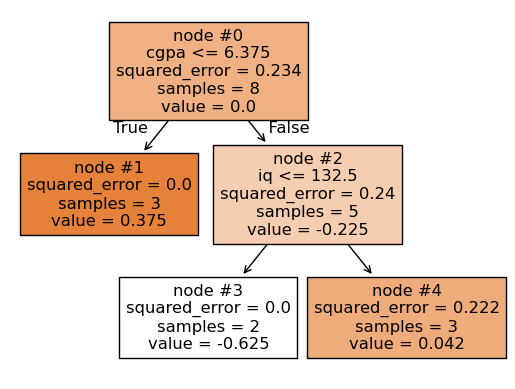

In [73]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plot_tree(reg1, feature_names=['cgpa','iq'],filled=True, node_ids=True)
plt.show()

- We can see the first split is based on CGPA, and the second split is based on IQ.
- So this is my second function, \( f_1(X) \).
- Now, next, I want to make the third model, which will be made with the combination of \( f_0(X) \) and \( f_1(X) \).
- Now we need to understand how the combination of \( f_0 \) and \( f_1 \) will do the prediction.
- The first model prediction is the log odds value.
- Now we need to understand how Model 2 does the prediction.
  - In the case of regression, the output of the decision tree was the value on its leaf node.
  - In the case of classification, there's a difference since the decision tree for classification is trained on the basis of residuals, and residuals are actually the difference in probabilities. So the values we see at the leaf node (i.e., 0.375, -0.625, 0.042) are actually the probabilities.
- We can add these probabilities to our Model 1 log odds value.
- So the values of the leaf node need to be converted into log odds.
- Now, using `sklearn`, we will find out which rows fall into which leaf node, and then use the formula to convert the values of each leaf node into log odds.

Formula:

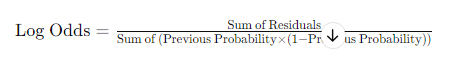

In [74]:
df['leaf_entry1'] = reg1.apply(df.iloc[:,0:2])
df

,cgpa,iq,is_placed,pre1(log-odds),pre1(probability),res1,leaf_entry1
0,6.82,118,0,0.510826,0.625,-0.625,3
1,6.36,125,1,0.510826,0.625,0.375,1
2,5.39,99,1,0.510826,0.625,0.375,1
3,5.50,106,1,0.510826,0.625,0.375,1
4,6.39,148,0,0.510826,0.625,-0.625,4
5,9.13,148,1,0.510826,0.625,0.375,4
6,7.17,147,1,0.510826,0.625,0.375,4
7,7.72,72,0,0.510826,0.625,-0.625,3


- Let's calculate for leaf node 3, which has 3 samples.

  Given:
  - Probabilities at leaf nodes are \( -0.625 \) and \( 0.625 \)
  - Number of samples in leaf node 3 = 3

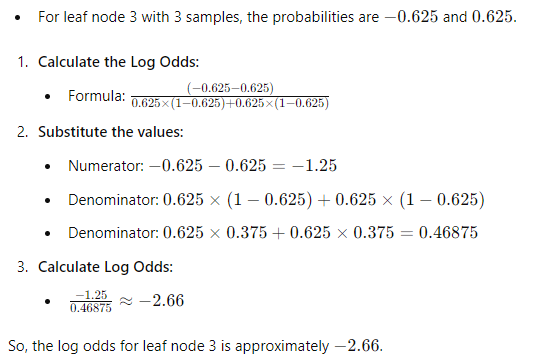


In [75]:
def return_logs(leaf):
  temp_df = df[df['leaf_entry1'] == leaf]
  num = temp_df['res1'].sum()

  den = sum(temp_df['pre1(probability)'] * (1 - temp_df['pre1(probability)']))
  return round(num/den,2)

In [76]:
df['pre2(log-odds)'] = df['pre1(log-odds)'] + df['leaf_entry1'].apply(return_logs)

In [77]:
df['pre2(probability)'] = 1/(1+np.exp(-df['pre2(log-odds)']))
df

,cgpa,iq,is_placed,pre1(log-odds),pre1(probability),res1,leaf_entry1,pre2(log-odds),pre2(probability)
0,6.82,118,0,0.510826,0.625,-0.625,3,-2.159174,0.103477
1,6.36,125,1,0.510826,0.625,0.375,1,2.110826,0.891951
2,5.39,99,1,0.510826,0.625,0.375,1,2.110826,0.891951
3,5.50,106,1,0.510826,0.625,0.375,1,2.110826,0.891951
4,6.39,148,0,0.510826,0.625,-0.625,4,0.690826,0.666151
5,9.13,148,1,0.510826,0.625,0.375,4,0.690826,0.666151
6,7.17,147,1,0.510826,0.625,0.375,4,0.690826,0.666151
7,7.72,72,0,0.510826,0.625,-0.625,3,-2.159174,0.103477


### Model Combination and Calculation

We have two models:

1. **Model 1:**
   - Output (Log Odds) = 0.51

2. **Model 2:**
   - Decision Tree model, which provides Log Odds for each leaf node.

**Objective:**
- Create a 3rd model which is the sum of the outputs from Model 1 and Model 2.
- For each row, calculate the overall Log Odds value by summing the predictions from both models.

#### Example Calculation for 1st Row

- The 1st row falls into leaf node 3 of the Decision Tree.
- The Log Odds value from Model 2 for this leaf node is \(-2.15\).

**Overall Log Odds Calculation for 1st Row:**
\[
\text{Overall Log Odds} = \text{Log Odds from Model 1} + \text{Log Odds from Model 2}
\]
\[
\text{Overall Log Odds} = 0.51 + (-2.15)
\]
\[
\text{Overall Log Odds} = -1.64
\]

**Repeat the above calculation for all rows.**

### Next Steps

- Calculate the probability from the overall Log Odds value.
- Use this probability to compute the residuals.


In [78]:
df['res2'] = df['is_placed'] - df['pre2(probability)']
df

,cgpa,iq,is_placed,pre1(log-odds),pre1(probability),res1,leaf_entry1,pre2(log-odds),pre2(probability),res2
0,6.82,118,0,0.510826,0.625,-0.625,3,-2.159174,0.103477,-0.103477
1,6.36,125,1,0.510826,0.625,0.375,1,2.110826,0.891951,0.108049
2,5.39,99,1,0.510826,0.625,0.375,1,2.110826,0.891951,0.108049
3,5.50,106,1,0.510826,0.625,0.375,1,2.110826,0.891951,0.108049
4,6.39,148,0,0.510826,0.625,-0.625,4,0.690826,0.666151,-0.666151
5,9.13,148,1,0.510826,0.625,0.375,4,0.690826,0.666151,0.333849
6,7.17,147,1,0.510826,0.625,0.375,4,0.690826,0.666151,0.333849
7,7.72,72,0,0.510826,0.625,-0.625,3,-2.159174,0.103477,-0.103477


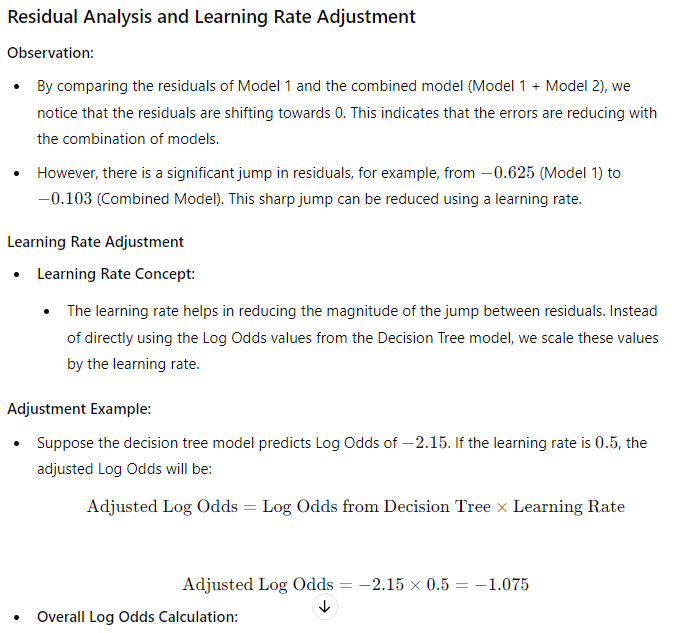
-
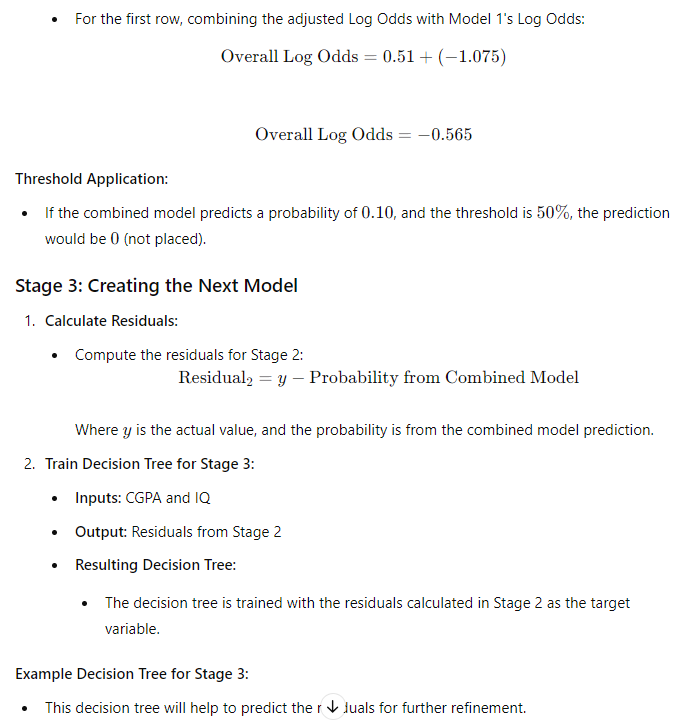
-
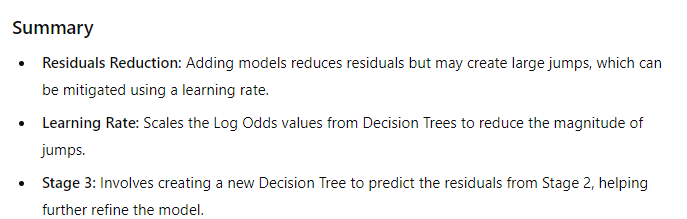

In [79]:
reg2 = DecisionTreeRegressor(max_leaf_nodes=3, random_state=1)

reg2.fit(df.iloc[:,0:2].values, df.iloc[:,-1].values)

DecisionTreeRegressor(max_leaf_nodes=3, random_state=1)

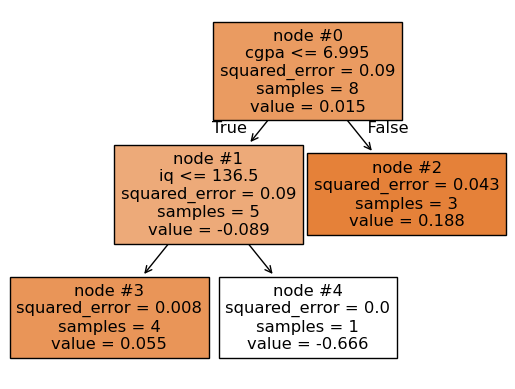

In [80]:
plot_tree(reg2, feature_names=['cgpa','iq'],filled=True, node_ids=True)
plt.show()

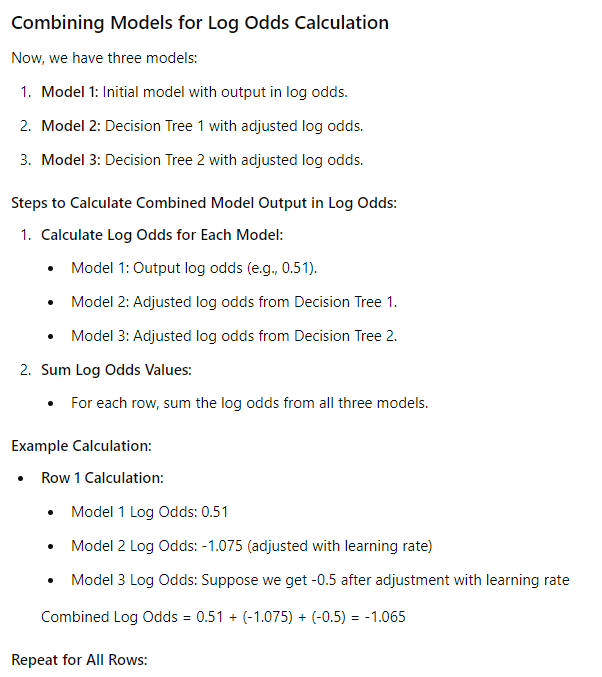
-
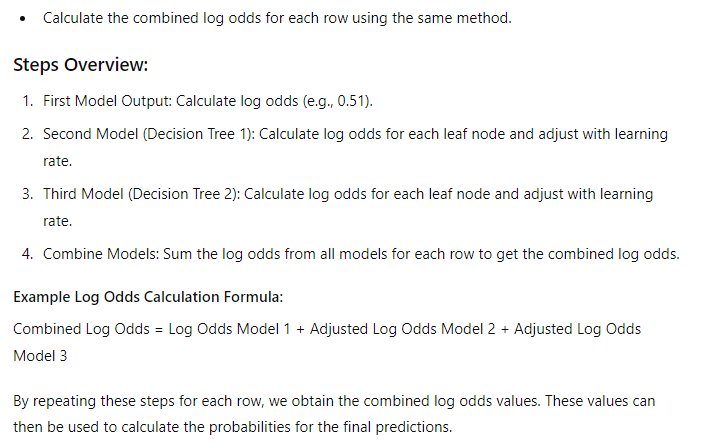

In [81]:
df['leaf_entry2'] = reg2.apply(df.iloc[:,0:2])
df

,cgpa,iq,is_placed,pre1(log-odds),pre1(probability),res1,leaf_entry1,pre2(log-odds),pre2(probability),res2,leaf_entry2
0,6.82,118,0,0.510826,0.625,-0.625,3,-2.159174,0.103477,-0.103477,3
1,6.36,125,1,0.510826,0.625,0.375,1,2.110826,0.891951,0.108049,3
2,5.39,99,1,0.510826,0.625,0.375,1,2.110826,0.891951,0.108049,3
3,5.50,106,1,0.510826,0.625,0.375,1,2.110826,0.891951,0.108049,3
4,6.39,148,0,0.510826,0.625,-0.625,4,0.690826,0.666151,-0.666151,4
5,9.13,148,1,0.510826,0.625,0.375,4,0.690826,0.666151,0.333849,2
6,7.17,147,1,0.510826,0.625,0.375,4,0.690826,0.666151,0.333849,2
7,7.72,72,0,0.510826,0.625,-0.625,3,-2.159174,0.103477,-0.103477,2


In [82]:
def return_logs(leaf):
  num = df[df['leaf_entry2'] == leaf]['res2'].sum()
  den = sum(df[df['leaf_entry2'] == leaf]['pre2(probability)'] * (1 - df[df['leaf_entry2'] == leaf]['pre2(probability)']))
  return round(num/den,2)

In [83]:
df['pre3(log-odds)'] = df['pre1(log-odds)'] + df['pre2(log-odds)'] + df['leaf_entry2'].apply(return_logs)

- pre2(log-odds) is basivcally the combination of model 1 and 2 log odds 

In [84]:
df['pre3(probability)'] = 1/(1+np.exp(-df['pre3(log-odds)']))
df

,cgpa,iq,is_placed,pre1(log-odds),pre1(probability),res1,leaf_entry1,pre2(log-odds),pre2(probability),res2,leaf_entry2,pre3(log-odds),pre3(probability)
0,6.82,118,0,0.510826,0.625,-0.625,3,-2.159174,0.103477,-0.103477,3,-1.068349,0.255717
1,6.36,125,1,0.510826,0.625,0.375,1,2.110826,0.891951,0.108049,3,3.201651,0.960896
2,5.39,99,1,0.510826,0.625,0.375,1,2.110826,0.891951,0.108049,3,3.201651,0.960896
3,5.50,106,1,0.510826,0.625,0.375,1,2.110826,0.891951,0.108049,3,3.201651,0.960896
4,6.39,148,0,0.510826,0.625,-0.625,4,0.690826,0.666151,-0.666151,4,-1.798349,0.142052
5,9.13,148,1,0.510826,0.625,0.375,4,0.690826,0.666151,0.333849,2,2.251651,0.904793
6,7.17,147,1,0.510826,0.625,0.375,4,0.690826,0.666151,0.333849,2,2.251651,0.904793
7,7.72,72,0,0.510826,0.625,-0.625,3,-2.159174,0.103477,-0.103477,2,-0.598349,0.354722


In [85]:
df['res_final'] = df['is_placed'] - df['pre3(probability)']

df[['res1','res2','res_final']]

,res1,res2,res_final
0,-0.625,-0.103477,-0.255717
1,0.375,0.108049,0.039104
2,0.375,0.108049,0.039104
3,0.375,0.108049,0.039104
4,-0.625,-0.666151,-0.142052
5,0.375,0.333849,0.095207
6,0.375,0.333849,0.095207
7,-0.625,-0.103477,-0.354722


- so we have our combined model using this will do prediction for new data point

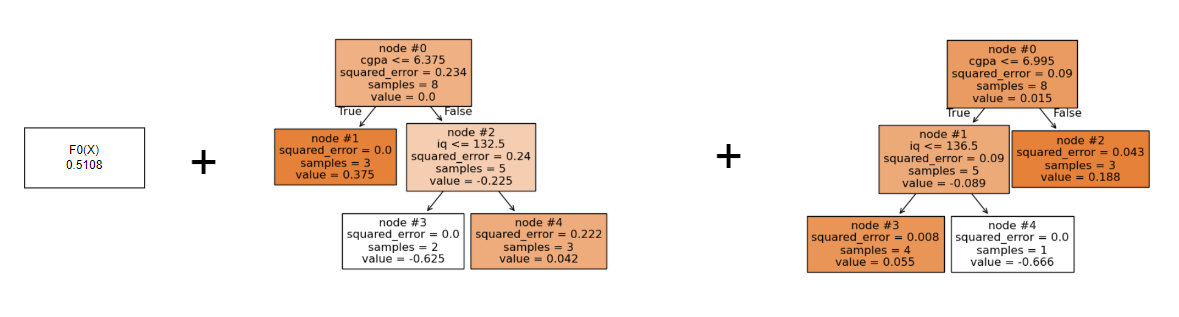

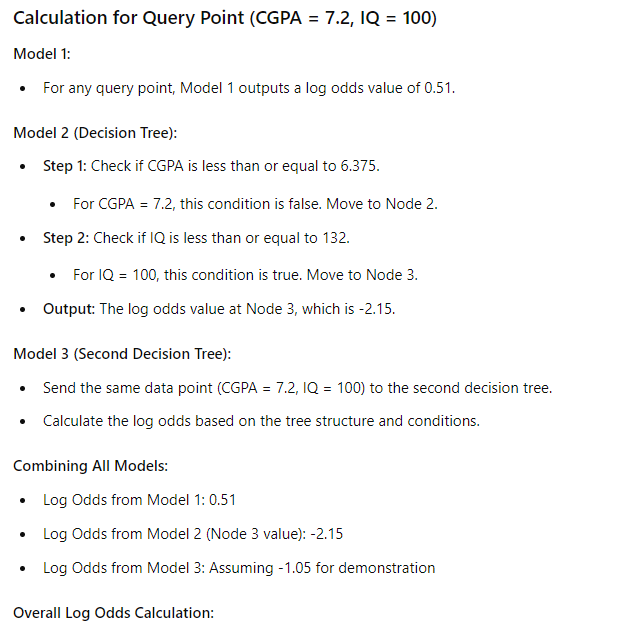
-
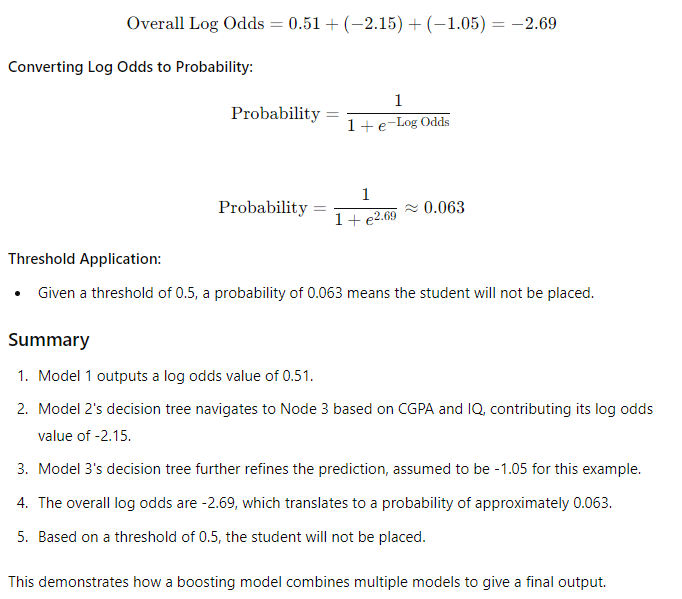